Last time we explored composite quadrature rules to approximate the integral of a function *f(x)* on some interval [a,b].  These quadrature rules were constructed by approximating *f(x)* with an interpolating polynomial *C(x)* and summing contributions ala the Riemann sum.  Such methods can be used to evaluate many integrals, but fail or are impractical for many integrals we may encounter in our studies.  One conspicuous example is when the domain of integration is infinite, e.g. $\int_0^{\infty} e^{-x} dx = 1$.  Problems can occur though even when the interval of integration is finite, for example, when the integrand contains a singularity on the interval of integration, e.g. $I = \int_0^1 \frac{1}{\sqrt{\sin{x}}} dx$.

In [1]:
import sys
import numpy as np
from os import getcwd
path='/'.join(getcwd().split('/')[:-1])+'/tools/'
sys.path.append(path)
from quadrature import midpoint,trapezoid,simpson

In [2]:
def testf(x):
    return 1./np.sqrt(np.sin(x))

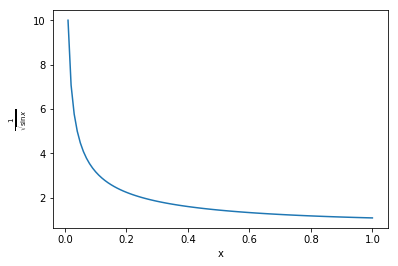

In [3]:
## plot f(x) on the interval of integration
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel(r'$\frac{1}{\sqrt{\sin{x}}}$')
xvals = np.linspace(0,1,101)[1:]
ax.plot(xvals,testf(xvals))

From the plot above we can see that *f(x)* has a singularity at x=0, i.e. $f(x)\rightarrow\infty$ as $x\rightarrow0$.  Let's try to evaluate the integral using the Simpson rule we wrote last class.

In [4]:
print('Simpson approximation of 1/sqrt(sin(x)) on [0,1] = ',simpson(testf,0,1,10))

Simpson approximation of 1/sqrt(sin(x)) on [0,1] =  inf


/util/opt/anaconda/deployed-conda-envs/packages/python/envs/python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


We've run into a problem because *f(x)* is infinite for x=0. Let's try again, omitting the left endpoint of the integration interval.

In [5]:
print('Simpson approximation of 1/sqrt(sin(x)) on [0,1] = ',simpson(testf,np.linspace(0,1,10)[1:]))

Simpson approximation of 1/sqrt(sin(x)) on [0,1] =  1.3681592519696708


We got a finite result, which is good.  However, to obtain this result we limited our evaluation of *f(x)* to [1/9,1].  From the plot above, this is likely problematic as a significant amount of the area under the curve is between 0 and 1/9.  Let's calculate a few more times, increasing the number of subintervals.

In [6]:
nsubintervals = np.power(10,np.arange(1,5))
for nsubs in nsubintervals:
    print('Simpson approximation of 1/sqrt(sin(x)) on [0,1] with %d subintervals = ' % (nsubs),simpson(testf,np.linspace(0,1,nsubs)[1:]))

Simpson approximation of 1/sqrt(sin(x)) on [0,1] with 10 subintervals =  1.3681592519696708
Simpson approximation of 1/sqrt(sin(x)) on [0,1] with 100 subintervals =  1.8338450223929366
Simpson approximation of 1/sqrt(sin(x)) on [0,1] with 1000 subintervals =  1.971543105423939
Simpson approximation of 1/sqrt(sin(x)) on [0,1] with 10000 subintervals =  2.014809056298098


As we increase the number of subintervals, and thus decrease the interval that we "discard", the result increases and appears to (slowly) converge.  Let's evaluate this integral using the **quad** method in the **scpy.integrate** package.  This method uses more advanced quadrature techniques to obtain a better approximation which we take to be the **true** value.

In [7]:
from scipy.integrate import quad
exact,exact_err = quad(testf,0,1)
print('Integral of 1/sqrt(sin(x)) on [0,1] = ', exact, ' with error ', exact_err)

Integral of 1/sqrt(sin(x)) on [0,1] =  2.0348053192075737  with error  9.121112753973648e-10


Knowing the true value, let's explore the converge of the Simpson rule.  One way to do this is to determine (approximately) how long it takes to achieve a value within some threshold of the true value.  Here, by "how long", we consider both the number of subintervals and the execution time.

In [8]:
from math import fabs
import time

relerrs = np.power(10.,-1*np.arange(1,5))
svals,nsubs,times = np.zeros(np.shape(relerrs)),np.ones(np.shape(relerrs),dtype=np.int),np.zeros(np.shape(relerrs))
for ierr,rerr in enumerate(relerrs):
    nsub,sval,relerr = nsubs[ierr if ierr == 0 else ierr-1],0,1
    while relerr > rerr:
        t0 = time.time()
        sval = simpson(testf,np.linspace(0,1,nsub)[1:])
        relerr = fabs(exact-sval)/exact
        nsub *= 3
    times[ierr] = time.time()-t0
    svals[ierr] = sval
    nsubs[ierr] = nsub

In [9]:
for ierr,rerr in enumerate(relerrs):
    print('Simpson rule required %.4f s to approximate integral with relative error %.4f using %d subintervals.' % (times[ierr],rerr,nsubs[ierr])) 

Simpson rule required 0.0004 s to approximate integral with relative error 0.1000 using 729 subintervals.
Simpson rule required 0.0277 s to approximate integral with relative error 0.0100 using 59049 subintervals.
Simpson rule required 0.1957 s to approximate integral with relative error 0.0010 using 4782969 subintervals.
Simpson rule required 16.2067 s to approximate integral with relative error 0.0001 using 387420489 subintervals.


growth in subintervals with relative error:  [810. 810. 810.]
growth in time with relative error:  [736.84879288  70.76082083 828.28437011]


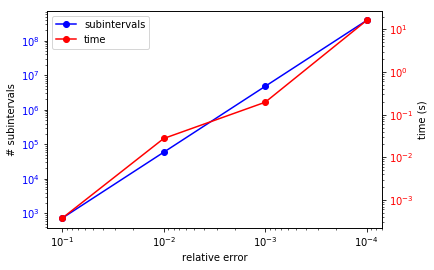

In [10]:
fig,ax=plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(relerrs,nsubs,'ob-',label='subintervals')
ax.set_xlabel('relative error')
ax.set_ylabel('# subintervals')
ax.tick_params(axis='y', labelcolor='b')
ax1 = ax.twinx()
ax1.set_ylabel('time (s)')
ax1.plot(relerrs,times,'or-',label='time')
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_yscale('log')
plt.gca().invert_xaxis()
handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax1.get_legend_handles_labels()
ax.legend(handles+handles1,labels+labels1)
print('growth in subintervals with relative error: ',(nsubs[1:]/nsubs[:-1])/(relerrs[1:]/relerrs[:-1]))
print('growth in time with relative error: ',(times[1:]/times[:-1])/(relerrs[1:]/relerrs[:-1]))

These results are merely representative, but the general behavior holds

A couple observations.  Each order of magnitude improvement in the approximation of the integral requires a number of subintervals that is roughly three orders of magnitude larger.  Worse, the execution time grows exponentially.  To achieve a precision of $10^{-4}$ requires about $10^8$ subintervals and 25 s.  Based on the above, to obtain a precision of $10^{-5}$ we might expect to require $10^{11}$ subintervals and a full work day of execution time!  Further improvements in precision will continue to require more resources.  At some point, simple quadrature rules will not suffice.  Approximating integrals with infinite domains of integration or integrands with singularities can sometimes still be accomplished by transforming the integral or using more advanced techniques such as Gaussian quadrature.  A version of the latter is employed by the scipy.integrate.quad method used above and is discussed in the class notes.

These are not the only difficulties we may encounter.  The dimensionality of the integral can present challenges.  Compared to a one-dimensional integral evaluated with $N$ subintervals, evaluating a $k$-dimensional integral with the same number of subintervals per dimension requires $N^k$ evaluations.  Thus, if we need to double the number of intervals to reduce the error in a one-dimensional integral by half, we need to perform $2^k$ evaluations to reduce it by a similar amount in $k$-dimensions.  To achieve an order of magnitude improvement in a $k$-dimensional integral requires roughly $2^{3k}$ evaluations and (at least) a corresponding increase in execution time.  To put some numbers to this, if a one-dimensional integral takes 1s to evaluate, achieving an order of magnitude improvement in the same integral takes a few seconds.  But achieving the same improvement in a 10-dimensional integral will require on the order of $2^{30}$ which is a **few decades**!  In practice this isn't necessarily the case, but at some point this begins to be a problem.  These integrals may sound extreme, but we will frequently encounter integrals with dimensionality many orders of magnitude greater.  Consider, to describe gas molecules in a box requires 6 quantities for each molecule $(\vec{x},\vec{p})$ and the number of particles can be very large.  Thus, new methods are required to address such integrals.  We turn now to one powerful tool in their evaluation.

Monte Carlo methods are a class of numerical techniques for calculating probabilities and related quantities, such as integrals, using sequences of random numbers.  The general approach we will explore can be broadly summarized as follows.

1. Generate a sequence of random values $r_1,r_2,\ldots$ according to a uniform distribution in the interval $0 < r< 1$.
2. Transform the sequence of $r_n$ so that they are distributed according to some probablity density function (p.d.f) $f(x)$ in which we are interested.
3. Use the random values distributed according to the p.d.f. $f(x)$ to calculate the integral of interest.

This sounds simple, but there is a lot going on here and we will spend the next two or three classes exploring these methods.  Let's start by taking a look at uniformly distributed random numbers.

Text(0.5,1,'uniform distribution on [0,1)')

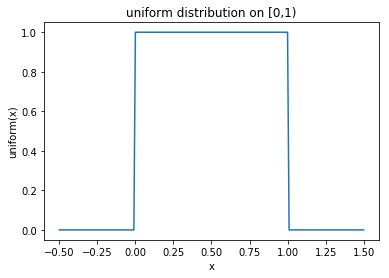

In [11]:
from scipy.stats import uniform
rv = uniform()
x = np.linspace(-0.5,1.5,201)
fig, ax = plt.subplots()
ax.plot(x,uniform.pdf(x))
ax.set_xlabel('x')
ax.set_ylabel('uniform(x)')
ax.set_title('uniform distribution on [0,1)')

This is the *uniform distribution* or sometimes the *continuous uniform distribution*. More exactly, this is the p.d.f. of the uniform distribution defined on [0,1]. The uniform pdf defined on a finite, continuous interval $[a,b]$ is 

$\begin{equation}
u(x) = \begin{cases} 
      \frac{1}{b-a} & x\in[a,b] \\
      0 & \mathrm{otherwise}
   \end{cases}
\end{equation}$

A random number drawn from a uniform pdf has a probability $u(x)dx$ of having a value between $x$ and $x+dx$. A proper pdf is normalized so that the total probability is 1, i.e. $\int_a^b f(x) dx = 1$.  How do we "draw" random numbers from a pdf?  One way would be to use a physical process such as nuclear decay. However, this is not very practical in many cases. One class of algorithms used for this purpose are called *multiplicative linear congruential* algorithms.  A sequence of numbers is generated according to some rule, for example, $n_{i+1} = (an_i)\ \mathrm{mod}\ m$, where $a,m$ are integer constants $n_0$ is a provided seed.  Once these values are set, the algorithm is, of course, deterministic.  These numbers are sometimes called *psueduorandom*.  Let's start by generating some random values from the uniform distribution.

Text(0.5,1,'$10^6$ numbers drawn from u(x;0,1)')

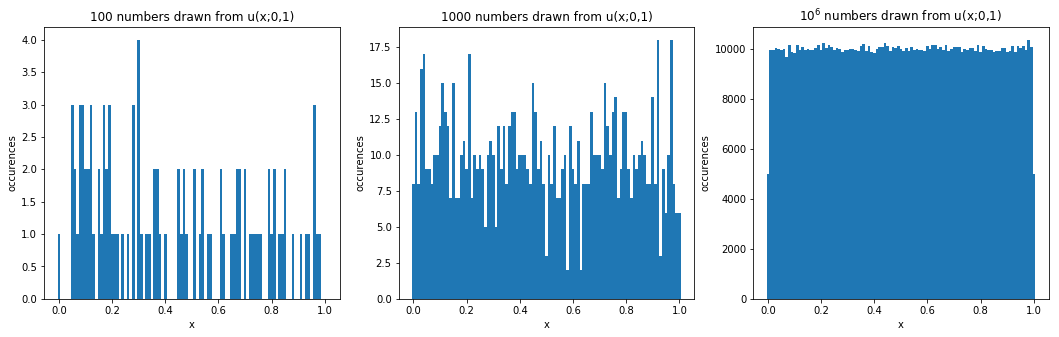

In [12]:
import numpy.random as rand
import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,3,sharex=True,figsize=(18,5))
counts0,bins0,_=axs[0].hist(rand.random(10**2),bins=np.linspace(-0.005,1.005,102))
counts1,bins1,_=axs[1].hist(rand.random(10**3),bins=np.linspace(-0.005,1.005,102))
counts2,bins2,_=axs[2].hist(rand.random(10**6),bins=np.linspace(-0.005,1.005,102))
axs[0].set_xlabel('x')
axs[0].set_ylabel('occurences')
axs[0].set_title('100 numbers drawn from u(x;0,1)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('occurences')
axs[1].set_title('1000 numbers drawn from u(x;0,1)')
axs[2].set_xlabel('x')
axs[2].set_ylabel('occurences')
axs[2].set_title(r'$10^6$ numbers drawn from u(x;0,1)')

Above are histograms displaying a set of *n* values drawn from a uniform pdf u(x;0,1), i.e. from a continuous uniform distribution on the interval [0,1].  The *x*-axis is divided into a finite number of bins (of uniform width in this case, but not required). The number of entries $n_i$ in subinterval $i$ is given on the vertical axis. The area of the histogram can be computed via Riemann sum, $\sum_{i=1}^{m} n_{i}\Delta x_i$. A histogram can be used as a pdf for discrete $x$, with $f_i = f(x_i) = P(x_i) = $ probability to observe $x_i$ with $\sum_{i=1}^{m}f_i = 1$.  The pdf $f(x)$ of the continuous random variable $x$ is obtained from a normalized histogram in the limit of zero bin width and an infinitely number of entries.

The *cumulative distribtuion function F(x)*, denoted cdf, is related to the pdf by $F(x) = \int_{-\infty}^x f(y)dy$.  The cdf is thus the probability for the random variable $x$ to have a value less than or equal to $x$.  For the uniform pdf u(x;0,1), the corresponding cdf is:

Text(0.5,1,'cdf of uniform distribution on [0,1]')

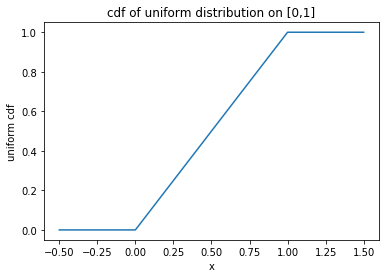

In [13]:
fig, ax = plt.subplots()
ax.plot(x,uniform.cdf(x))
ax.set_xlabel('x')
ax.set_ylabel('uniform cdf')
ax.set_title('cdf of uniform distribution on [0,1]')

The same ideas can be extended to more than one dimension.  The pdf u(x,y) is sometimes referred to as the **joint pdf** and probability to obtain a value of $x$ in $[x,x+dx]$ and $y$ in $[y,y+dy]$ is given by $P(A\cap B ) = u(x,y)dxdy$, where *A* is an event corresponding to the observation $x\in[x,x+dx]$ and *B* the observation $y\in[y,y+dy]$.

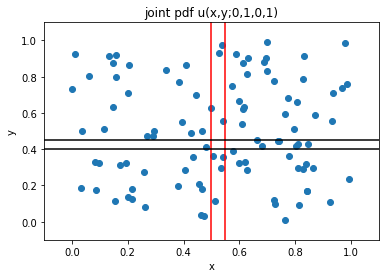

In [14]:
fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('joint pdf u(x,y;0,1,0,1)')
xvals = rand.random(10**2)
yvals = rand.random(10**2)
ax.scatter(xvals,yvals)
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-0.1,1.1)
ax.plot(0.5*np.ones(101),np.linspace(-0.1,1.1,101),'r')
ax.plot(0.55*np.ones(101),np.linspace(-0.1,1.1,101),'r')
ax.plot(np.linspace(-0.1,1.1,101),0.4*np.ones(101),'k')
ax.plot(np.linspace(-0.1,1.1,101),0.45*np.ones(101),'k')

As before, to be a proper pdf f(x,y) must be normalized, i.e. $\int\int_{\mathcal{S}} f(x,y)dxdy = 1$.  From the joint pdf, we can obtain the pdf for a single random variable by integrating out (or summing over) the other variables, i.e. $P(A) = \sum_i f(x,y_i)dy_idx = f_{x}(x) = \int_{-\infty}^{\infty} f(x,y)dy$. The quantity $f_x(x)$ is referred to as the *marginal pdf for x*.  Similarly, the marginal pdf for y if $f_y(y) = \int_{-\infty}^{\infty} f(x,y)dx$.  The marginal pdfs in x (y) correspond to the normalized histograms obtained by projecting a scatter plot onto the x (y) axis.

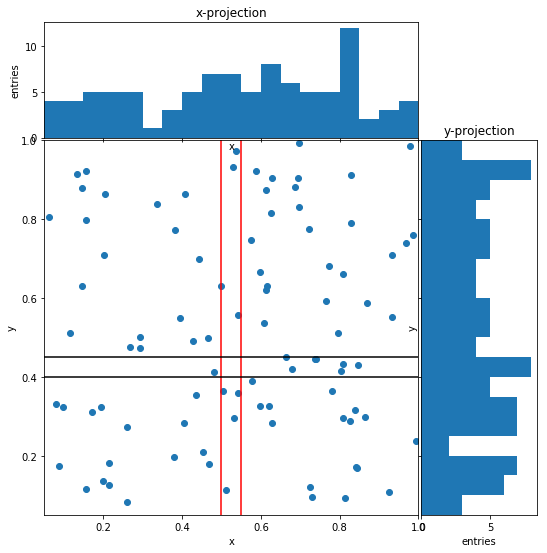

In [15]:
## example based on https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    xymin = min(np.min(np.abs(x)), np.min(np.abs(y)))
    binwidth = 0.05    
    limax = (int(xymax/binwidth) + 1) * binwidth
    limin = (int(xymin/binwidth) + 1) * binwidth

    bins = np.arange(limin, limax + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    ax.set_xlabel('x')
    ax.set_ylabel('y') 
    ax.set_xlim(limin,limax)
    ax.set_ylim(limin,limax)
    ax_histx.set_xlabel('x')
    ax_histy.set_ylabel('y') 
    ax_histx.set_ylabel('entries')
    ax_histy.set_xlabel('entries') 
    ax_histx.set_title('x-projection')
    ax_histy.set_title('y-projection')
    ax.plot(0.5*np.ones(101),np.linspace(limin,limax,101),'r')
    ax.plot(0.55*np.ones(101),np.linspace(limin,limax,101),'r')
    ax.plot(np.linspace(-0.1,1.1,101),0.4*np.ones(101),'k')
    ax.plot(np.linspace(-0.1,1.1,101),0.45*np.ones(101),'k')    
        
    
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(xvals, yvals, ax, ax_histx, ax_histy)

We will also encounter functions of random variables, which are themselves random variables.  Consider $a(x)$ a continuous function of a (continuous) random variable $x$, with $x$ distributed according to pdf $f(x)$.  What is the pdf $g(a)$ that describes the distribution of $a(x)$?  We can determine this by requiring that the probability to find $a\in[a,a+da]$ is equal to the probability to obtain $x\in[x,x+dx]$, i.e. $g(a')da' = \int_{d\mathcal{S}}f(x)dx$, where the integral is performed over the region in $x$-space bounded by $a(x) = a'$ and $a(x) = a' + da'$.

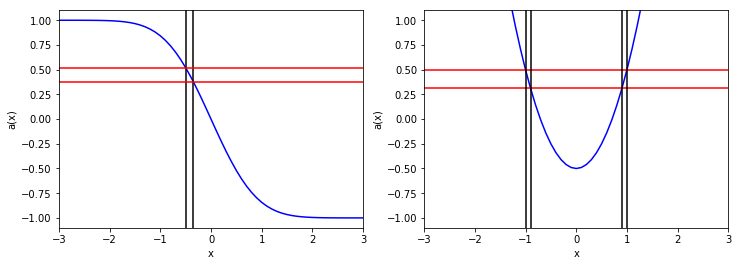

In [16]:
from scipy.special import erf
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].set_xlabel('x')
axs[0].set_ylabel('a(x)')
axs[0].set_ylim(-1.1,1.1)
axs[0].set_xlim(-3,3)
#axs[0].set_title('f(x) = -erf(x)')
xvals = np.linspace(-3,3,61)
axs[0].plot(xvals,-erf(xvals),'b')
axs[0].plot(-0.5*np.ones(23),np.linspace(-1.1,1.1,23),'k')
axs[0].plot(-0.35*np.ones(23),np.linspace(-1.1,1.1,23),'k')
axs[0].plot(np.linspace(-3,3,23),-erf(-0.5)*np.ones(23),'r')
axs[0].plot(np.linspace(-3,3,23),-erf(-0.35)*np.ones(23),'r')

axs[1].set_xlabel('x')
axs[1].set_ylabel('a(x)')
axs[1].set_ylim(-1.1,1.1)
axs[1].set_xlim(-3,3)
#axs[1].set_title(r'f(x) = $x^2 - 0.5$')
axs[1].plot(xvals,xvals**2 - 0.5,'b')
axs[1].plot(np.linspace(-3,3,23),0.5*np.ones(23),'r')
axs[1].plot(np.linspace(-3,3,23),0.31*np.ones(23),'r')
axs[1].plot(-1*np.ones(23),np.linspace(-1.1,1.1,23),'k')
axs[1].plot(1*np.ones(23),np.linspace(-1.1,1.1,23),'k')
axs[1].plot(-0.9*np.ones(23),np.linspace(-1.1,1.1,23),'k')
axs[1].plot(0.9*np.ones(23),np.linspace(-1.1,1.1,23),'k')

If $a(x)$ can be inverted to obtain $x(a)$, as in above left, then we obtain $$g(a)da = \left|\int_{x(a)}^{x(a+da)}f(x')dx'\right| = \int_{x(a)}^{x(a)+\left|\frac{dx}{da}\right|da}f(x')dx' \rightarrow g(a) = f(x(a))\left|\frac{dx}{da}\right|.$$

If $a(x)$ does not have a unique inverse, then the integral must be performed over all regions in space between  $a(x) = a'$ and $a(x) = a' + da'$, as in above right.  These results can be extended to more than one random variable.

The idea of Monte Carlo integration follows from the mean-value theorem in calculus, which states that the integral of a function $f(x)$ on an interval $[a,b]$ is equal to the length of the integration interval, $b-a$, times the average value of the function on that interval, $\langle f\rangle$.  That is, $\int_a^b f(x) dx = (b-a)\langle f\rangle$.  Thus, we've reduced the problem of integrating $f(x)$ on some interval to one of calculating the average $\langle f\rangle$ on that same interval.

The *expectation value* $E[x]$ of a random variable *x* distributed according to a pdf $f(x)$ is defined as $E[x] = \int_{-\infty}^{\infty} xf(x)dx = \mu$.  The expectation value of $x$, also called the *population meamn* or the *mean*, is denoted as $\mu$. Note that $E[x]$ is not a function of $x$ but rather depends on the pdf $f(x)$.  For a sequence of values sampled from a uniform distribution f(x) = u(x;0,1) the mean is $\langle x\rangle = \frac{1}{N}\sum_{i=1}^{N}x_i$.

In [17]:
## calculate mean of x sampled from the uniform distribution u(x;0,1). what do you think it should be?
rvals = rand.random(100)
print('mean of x sampled from u(x;0,1) = ',rvals.mean())

mean of x sampled from u(x;0,1) =  0.4864581245591556


This can be expanded to higher order terms such as

$
\begin{equation}
E[x^n] = \int_{-\infty}^{\infty} x^nf(x)dx \hspace{40mm} n^{th}~\mathrm{algebraic\ moment} \\
\end{equation}
$

$
\begin{equation}
E[(x-E[x])^n] = \int_{-\infty}^{\infty} (x-\mu)^nf(x)dx \hspace{12mm} n^{th}~\mathrm{central\ moment} \\ 
\end{equation}
$
     
In particular, the second central moment $E[(x-E[x])^2] = \int_{-\infty}^{\infty} (x-\mu)^2f(x)dx = \sigma^2 = V[x]$ is the *population variance*, a measure of how widely $x$ is distributed about its mean value.  This can also be expressed as $E[(x-\mu)^2] = E[x^2] - \mu^2$.  Here, $\mu$ is the **true** mean, more on this below.  Frequently you may see reported the *standard deviation* of *x*, which is obtained by taking the square root of the variance.


In [18]:
print('variance of x sampled from u(x;0,1) = ',rvals.var())
print('std dev of x sampled from u(x;0,1) = ',np.sqrt(rvals.var()))
print('std dev of x sampled from u(x;0,1) = ',rvals.std())

variance of x sampled from u(x;0,1) =  0.08387218325390298
std dev of x sampled from u(x;0,1) =  0.2896069461423586
std dev of x sampled from u(x;0,1) =  0.2896069461423586


The variance above is calculated as $\sigma^2 = \frac{1}{N}\sum_{i=1}^N \frac{(x-\mu)^2}{N}$ which we now verify explicitly.

In [19]:
mean = np.sum(rvals)/np.size(rvals)
var = np.sum(np.power(rvals-mean,2))/np.size(rvals)
print('mean: ',mean)
print('variance: ', var)

mean:  0.4864581245591556
variance:  0.08387218325390298


This matches the results obtained above.  In general, the true mean $\mu$ is not known and so the sample mean is used instead, as in our explicit calculation.  In this case, one degree of freedom is constrained by the mean and so an unbiased estimator of the variance is $s^2 = \frac{1}{N-1}\sum_i (x_i - \overline{x})^2 = \frac{N}{N-1}\left(\langle x^2\rangle-\langle x\rangle^2\right)$.  Thus, as $N$ increases, the sample variance becomes a better estimator of the true variance.  Why is $s^2$ used as an estimator of the spread of the distribution and not, say, $s = \frac{1}{N-1}\sum_i x_i - \overline{x}$?

Note, $s$ is a measure of how spread out the distribution is, not how well the mean $\overline{x}$ is determined.  This is known to an accuracy better by a factor of $\sqrt{N}$.  Thus, by taking more observations, the variance $s^2$ will not change much as the numerator and denominator grow proportionally.  This makes sense as $s^2$ is an estimate of the variation of the population from which our numbers were sampled, which of course must be independent of how many number $N$ we sample.  The variance of the mean is $\frac{s^2}{N}$ which decreases with increasing $N$, i.e. the more observations we make the better we are able to estimate the true mean.  We may be tempted to conclude from this that we can obtain arbitrary accuracy in any experiment by just making more measurements, but this conclusion would lead us astray. Indeed, the *statistical uncertainty* in our measurement would decrease with increasing number of measurements, but this is not the only source of uncertainty.  In practice, at some point *systematic uncertainties* resulting from the design of the experiment and limitations of our measuring devices begin to dominate, at which point taking additional measurements will not improved the overall accuracy of our result.

Let's now turn our attention back to the uniform pdf $f(x) = u(x;0,1). 

In [20]:
print('mean: ',rvals.mean())
print('variance: ',rvals.var(ddof=1))

mean:  0.4864581245591556
variance:  0.08471937702414443


What if we wanted to determine the area under the curve of the uniform pdf, i.e. $\int_0^1 u(x;0,1)dx$?  To calculate the mean, we sampled numbers from $f(x)$, evaluated $x$, summed up all the "trials" and divided by the total number.  The integral is obtained when we set $x=1$, i.e. $E[1] = \int_0^1 f(x) dx = \frac{1}{N}\sum_{i=1}^{N} 1 = 1$, as expected.

We've focused up to now on the rooting of this method in the fundamental concepts of calculus and probability theory.  These ideas also can be considered geometrically, which we will use to estimate the area of the unit circle as follows.

Consider a function $f(x,y)$ that we want to compute the integral of on some finite domain $\mathcal{S}$, where $\mathcal{S}$ is defined by a function $g(x,y)$ which is non-negative on $\mathcal{S}$ and $g(x,y)<0$ elsewhere.  The boundary of this region is then given by the equation $g(x,y) = 0$.  Let $A(\mathcal{S})$ be the area of the domain $\mathcal{S}$.  Then the integral of $g(x,y)$ on this domain can be estimated using Monte Carlo integration.  For the case of a circle, this can be done as follows:

1. Embed the domain $\mathcal{S}$ in some larger, rectangular space $R$.
2. Sample pairs of random numbers (x,y) from a uniform distribution defined on the domain $R$.
3. Count the fraction $q$ of sampled (x,y) pairs that lie inside of $\mathcal{S}$, i.e. for which $g(x,y)\neq0$.
4. Approximate $A(\mathcal{S}) = qA(R)$.
5. Evaluate the mean of $f(x,y), \langle f\rangle$, at points inside $\mathcal{S}$.
6. Estimate the integral as $A(\mathcal{S})\langle f\rangle$.

In [21]:
def mc_circle(f,g,x0,y0,r,n):
    x = rand.uniform(x0-r,x0+r,n)
    y = rand.uniform(y0-r,y0+r,n)
    xin = x[g(x,y,x0,y0,r)==1]
    yin = y[g(x,y,x0,y0,r)==1]
    fvals = f(xin,yin)
    fmean = np.mean(fvals)
    area = (np.size(xin)/float(n))*2*r*2*r
    return area*fmean

def g(x,y,x0,y0,r):
    r = np.sqrt(np.power(x-x0,2)+np.power(y-y0,2))
    return np.less_equal(r,np.ones(np.size(r)))

In [22]:
print('area of unit circle: ',mc_circle(lambda x,y: 1,g,0,0,1,100))
print('area of unit circle: ',mc_circle(lambda x,y: 1,g,0,0,1,1000))
print('area of unit circle: ',mc_circle(lambda x,y: 1,g,0,0,1,10000))
print('area of unit circle: ',mc_circle(lambda x,y: 1,g,0,0,1,100000))

area of unit circle:  3.2
area of unit circle:  3.044
area of unit circle:  3.1464
area of unit circle:  3.14036


Recall the procedure for the *direct method*.

1. Calculate the *cdf* for *pdf* $f(x)$, i.e. $F(X) = \int_a^x f(x) dx$.
2. Set $R = F(X)$ and solve for $x = F^{-1}(R)$.  
3. Generate $N$ values $\{R\}$ from a uniform distribution on finite interval $[a,b]$.  The resulting values $\{x\}$ will be distributed according to the *pdf* $f(x)$.

If $P(R)dR$ is a uniform distribution on the interval $[0,1]$, i.e. $P(R) = 1$, then we want $P(R)dR = dR = \frac{dR}{dx}dx = f(x)dx$.  Then values $x = F^{-1}(R)$ will be distributed according to $f(x)$ when $F(x) = \int_0^x f(w)dw$.  


Consider $f(\theta) = \frac{\sin\theta}{2}$ on the interval $[0,\pi]$.  $\int_0^\pi \frac{\sin\theta}{2} = 1$ so $f(\theta)$ is a proper *pdf*. Then $F(\theta) = \int_0^\theta \frac{\sin x}{2}dx = \frac{1-\cos\theta}{2}$ or $\cos\theta = 1 - 2R$.

integral of 0.5*sin(theta) on [0,pi] =  1.0


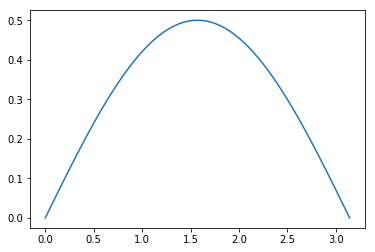

In [23]:
import math

def f(theta):
    return 0.5*np.sin(theta)

fig,ax = plt.subplots()
theta = np.linspace(0,math.pi,101)
ax.plot(theta,f(theta))

from scipy.integrate import quad
integral,err = quad(f,0,math.pi)
def print('integral of 0.5*sin(theta) on [0,pi] = ',integral)

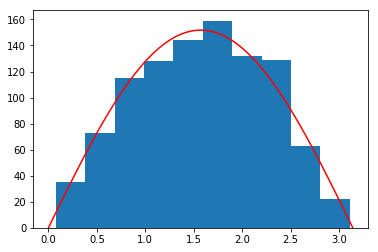

In [34]:
def g(R):
    return np.arccos(1-2*R)

N = 10**3
R = rand.random(N)
x = g(R)
fig,ax = plt.subplots()
counts,bins,_ = ax.hist(x)
bin_widths = bins[1:]-bins[:-1]
int_hist = np.sum(counts*bin_widths) ## normalize plot to histogram using integral of histogram = sum(bin_width*bin_count)
theta = np.linspace(0,math.pi,101)
ax.plot(theta,int_hist*f(theta),'r-')

The above method works well in many scenarios provided that

1. The functional form of the *pdf* $f(x)$ or the *cdf* $F(x)$ is known.
2. If $F(x)$ is not directly known, then $f(x)dx$ must be integrable.
3. $F(x)$ must be invertible.

If any of these conditions aren't met then the *direct method* cannot be applied.  It is easy to find simple examples that violate each of these assumptions.  For example, suppose we obtained a histogram based on some experimental measurements and want to use it as a *pdf*.  Even when the functional form is known though, criteria 2 and 3 are not necessarily easily met.

Consider, for example, the *pdf* $f(x) = 2x + 3x^2 - 4x^3$ on the interval $[0,1]$.

Integral of pdf is  (1.0, 1.1102230246251565e-14)


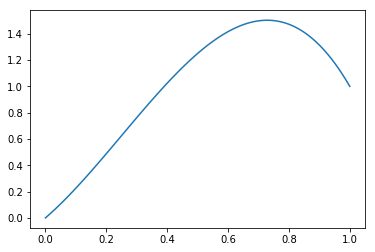

In [36]:
def f(x):
    return 2*x+3*x*x-4*x*x*x

x = np.linspace(0,1,101)
fig,ax = plt.subplots()
ax.plot(x,f(x))

print('Integral of pdf is ',quad(f,0,1))

Looks like a validate *pdf*.  The *cdf* is $F(x) = \int_0^x f(w)dw = x^2 + x^3 - x^4$.  However, the *cdf* $F(x)$ is not easily invertible and thus we are left unable to obtain $\{x\} = F^{-1}(R)$.  Instead, we turn to an alternate approach, the *acceptance-rejection method*.  The general strategy starting with a target *pdf* $f(x)$ defined on an interval $[a,b]$ is

1. Generate a uniform random value $x=R_1$ on the interval $[a,b]$.
2. Define a weight $w = \frac{f(x)}{y_{\mathrm{max}}}$, where $y_{\mathrm{max}}$ is the maximum value the *pdf* $f(x)$ takes on the interval.  By construction, $w\in[0,1]$.
3. Generate a uniform random value $R_2$ on the interval $[0,1]$.  Reject $x$ if $R_2 > w$ otherwise accept R_2.  The resulting distribution of values $\{x\}$ is distributed according to the *pdf* $f(x)$.

Let's return to the polynomial *pdf* above.

Accepted 658 values out of 1000 trials


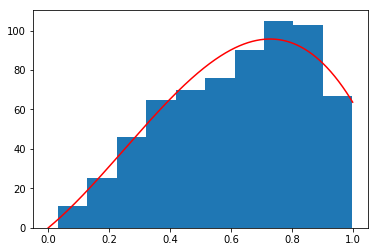

In [41]:
## find maximum of f(x)
x = np.linspace(0,1,10**6+1)
fvals = f(x)
ymax = fvals.max()

## first with loops
vals = []
for i in range(N):
    r1 = rand.random(1)
    w = f(r1)/ymax
    r2 = rand.random(1)
    if r2 <= w: vals.append(r1)
        
print('Accepted {} values out of {} trials'.format(len(vals),N))
fig,ax = plt.subplots()
counts,bins,_ = ax.hist(np.array(vals))
bin_widths = bins[1:]-bins[:-1]
int_hist = np.sum(counts*bin_widths) ## normalize plot to integral of histogram 
x = np.linspace(0,1,10**3+1)
ax.plot(x,int_hist*f(x),'r-')

Accepted 6672 values out of 10000 trials


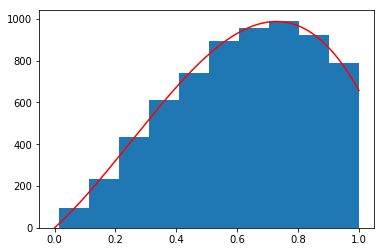

In [45]:
## same thing without the loop
N=10**4
r1 = rand.random(N)
w = f(r1)/ymax
r2 = rand.random(N)
vals = r1[r2<=w]

print('Accepted {} values out of {} trials'.format(np.size(vals),N))

fig,ax = plt.subplots()
counts,bins,_ = ax.hist(np.array(vals))
bin_widths = bins[1:]-bins[:-1]
int_hist = np.sum(counts*bin_widths) ## normalize plot to integral of histogram 
ax.plot(x,int_hist*f(x),'r-')

Pretty cool.  Starting from a simple geometrical argument we were able to construct a procedure that allows generate random numbers according to an arbitrary *pdf*.  This method has the advantage in that it allows us to  generate numbers according to a *pdf* $f(x)$ without any knowledge of the *cdf*. We can even use it to generate  values using a histogram as a *pdf*! The price for this is an inefficiency as only *some of the values are accepted*.  Above, we accepted 658/1000 and 6672/10000 for an acceptance rate of about 0.66.  This method works well provided the acceptance rate is not too extreme.  If the rate is close to 1 then we're effectively sampling a uniform distribution.  More often, if the rate is too low, i.e. too close to 0, then we must perform a very large number of trials to obtain a sample of the desired size.  To tackle challenges posed by low acceptance rates or non-finite intervals, we can combine the *direct method* and the *acceptance-rejection method* which we now consider.

Suppose we want to generate random values according to the *pdf* $f(x) = A\sqrt{x}e^{-3x/2}$ on the interval $[0,\infty)$.  Here, $A$ is an unknown normalization constant that could be determined numerically using quadrature methods.  Let's start by plotting $f(x)$.

In [60]:
fint,fint_err = quad(f,0,np.inf)

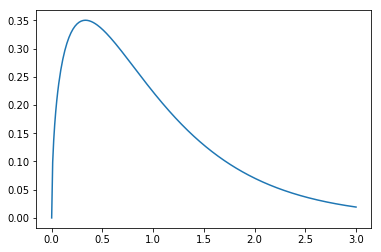

In [46]:
def f(x):
    return np.sqrt(x)*np.exp(-3*x/2.)

x = np.linspace(0,3,301)
fig,ax = plt.subplots()
ax.plot(x,f(x))

The *pdf* tends to 0 at both ends of the interval and is finite everywhere.  I don't know how to integrate this function and if I could I would also have to invert it so the *direct method* doesn't seem possible.  At the same time, I'm not sure how to use the *acceptance-rejection* method on an infinite interval.  Though neither method appears to work alone, it turns out that this problem can be made tractable by combining the two methods.  To start, let's select an alternate *pdf* $g(x)$ that has the same shape as and is always greater than our target *pdf* $f(x)$.  For example, let's take $g(x) = A\frac{e^{-x}}{\sqrt{e}}$.

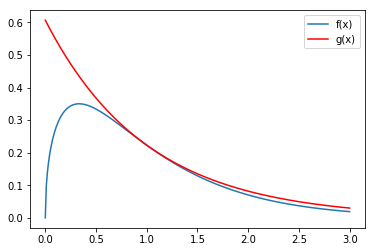

In [47]:
def g(x):
    return np.exp(-x)/np.sqrt(math.e)

fig,ax = plt.subplots()
ax.plot(x,f(x),label='f(x)')
ax.plot(x,g(x),'r-',label='g(x)')
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles,labels)

The proposal $g(x)$ appears to meet our purposes.  It has the same asypmtotic behavior as $f(x)$ and has value at least that of $f(x)$.  The *pdf* $g(x)$ can also be integrated and inverted so that we can obtain values distributed according to $g(x)$ using the *direct method*. The *cdf* corresponding to $g(x)$ is $G(x) = \int_0^x g(w)dw = 1-R$.  Inverting and solving yields $x = G^{-1}(R) = -\ln R$.  The procedure for the hybrid method becomes

1. Generate values $\{R\}$ that are uniformly distributed.
2. Determine the *cdf* for an alternate *pdf* $g(x)$ and use it to obtain values $\{x\} = G^{-1}(R)$ distributed according to the *pdf* $g(x)$.
3. Define weights $w = \frac{f(x)}{g(x)}$.
4. Generate values $\{R_2\}$ uniformly distributed on $[0,1]$.
5. Reject values of $x$ if $R_2 > w$ otherwise accept.

Let's follow this for the example above.

Acceptance rate:  0.79539


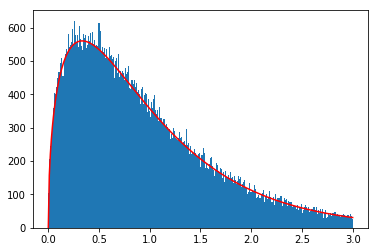

In [61]:
N = 10**5
r1 = rand.random(N)

def G(R):
    return -np.log(R)

x = G(r1)
w = f(x)/g(x)
r2 = rand.random(N)
vals = x[r2<=w]
print('Acceptance rate: ', np.size(vals)/float(N))

xvals = np.linspace(0,3,301)
fig,ax = plt.subplots()
counts,bins,_ = ax.hist(np.array(vals),bins=xvals)
bin_widths = bins[1:]-bins[:-1]
int_hist = np.sum(counts*bin_widths) ## normalize plot to integral of histogram, need to account for f(x) not normalized
ax.plot(xvals,(int_hist/fint)*f(xvals),'r-')